# PROJECT - GROUP 2

DESCRIZIONE DEL PROGETTO
Gruppo 2: Aiello Vincenzo, Guidi Gianluca, Longo Marzia, Mercanti Elisa

Il dataset utilizzato è: https://www.kaggle.com/rmisra/news-category-dataset.

Il nostro obiettivo sarà quello di costruire un predittore che permetta di classificare le news partendo dal titolo e dalla breve descrizione presente. 
Con la data understanding esploreremo il dataset, al fine di individuare quali features sono rilevanti.

In [1]:
# %pip install unidecode
# %pip install spacy
# %pip install nltk
# %pip install stopwords
# %pip install wordcloud
# %pip install altair

# DATA UNDERSTANDING

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import count, countDistinct, length, hour, year, month, date_format, desc, dayofweek, col , when, isnan
from pyspark.sql import functions as F, udf

from pyspark.mllib.linalg import Vectors
import altair as alt

In [3]:
spark = SparkSession.Builder().appName('Project').getOrCreate()

LETTURA DEL FILE JSON

In [4]:
document = spark.read.json("News_Category_Dataset_v2.json")
document.show()

+--------------------+-------------+----------+--------------------+--------------------+--------------------+
|             authors|     category|      date|            headline|                link|   short_description|
+--------------------+-------------+----------+--------------------+--------------------+--------------------+
|     Melissa Jeltsen|        CRIME|2018-05-26|There Were 2 Mass...|https://www.huffi...|She left her husb...|
|       Andy McDonald|ENTERTAINMENT|2018-05-26|Will Smith Joins ...|https://www.huffi...|Of course it has ...|
|          Ron Dicker|ENTERTAINMENT|2018-05-26|Hugh Grant Marrie...|https://www.huffi...|The actor and his...|
|          Ron Dicker|ENTERTAINMENT|2018-05-26|Jim Carrey Blasts...|https://www.huffi...|The actor gives D...|
|          Ron Dicker|ENTERTAINMENT|2018-05-26|Julianna Margulie...|https://www.huffi...|The "Dietland" ac...|
|          Ron Dicker|ENTERTAINMENT|2018-05-26|Morgan Freeman 'D...|https://www.huffi...|"It is not right ...|
|

In [5]:
dataframe_Pandas= document.toPandas()
document.toPandas()

,authors,category,date,headline,link,short_description
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ..."
...,...,...,...,...,...,...
200848,"Reuters, Reuters",TECH,2012-01-28,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,https://www.huffingtonpost.com/entry/rim-ceo-t...,Verizon Wireless and AT&T are already promotin...
200849,,SPORTS,2012-01-28,Maria Sharapova Stunned By Victoria Azarenka I...,https://www.huffingtonpost.com/entry/maria-sha...,"Afterward, Azarenka, more effusive with the pr..."
200850,,SPORTS,2012-01-28,"Giants Over Patriots, Jets Over Colts Among M...",https://www.huffingtonpost.com/entry/super-bow...,"Leading up to Super Bowl XLVI, the most talked..."
200851,,SPORTS,2012-01-28,Aldon Smith Arrested: 49ers Linebacker Busted ...,https://www.huffingtonpost.com/entry/aldon-smi...,CORRECTION: An earlier version of this story i...


VISUALIZZAZIONE DELLE FEATURES E DEI VALORI MANCANTI IN ESSE PRESENTI

In [6]:
document.printSchema()

root
 |-- authors: string (nullable = true)
 |-- category: string (nullable = true)
 |-- date: string (nullable = true)
 |-- headline: string (nullable = true)
 |-- link: string (nullable = true)
 |-- short_description: string (nullable = true)



Notiamo che nel dataset ci sono in totale 6 features differenti, tutte aventi type = string.
Come tipi di dati però sono:
- authors è una variabile che si può considerare nominale nonostante abbia un altissimo numero di modalità
- category è una variabile nominale
- la data è variabile tempo
- headline e short description e link sono dati non strutturati di tipo testuale

In [7]:
dataframe_Pandas.describe().transpose()

,count,unique,top,freq
authors,200853,27993,,36620
category,200853,41,POLITICS,32739
date,200853,2309,2013-05-07,100
headline,200853,199344,Sunday Roundup,90
link,200853,200812,https://www.huffingtonpost.comhttp://d.repubbl...,2
short_description,200853,178353,,19712


La funzione describe, di pandas, ci mostra il totale dei record e per ogni attributo vengono riportati il numero di valori unici e il valore della moda con la relativa frequenza.
Si nota che per “authors” e “short_description”, il valore più frequente coincide in realtà con i missing values.

Passiamo ad analizzare dunque tutti i missing values delle differenti features.

In [8]:
document.registerTempTable('document')
NA_authors = spark.sql('select count (*)  \
                            from document \
                            where authors== "" ')
NA_authors.toPandas()

,count(1)
0,36620


In [9]:
document.registerTempTable('document')
NA_authors = spark.sql('select count (*)  \
                            from document \
                            where authors is null ')
NA_authors.toPandas()

,count(1)
0,0


In [10]:
document.registerTempTable('document')
NA_category = spark.sql('select count (*)  \
                            from document \
                            where category== "" ')
NA_category.toPandas()

,count(1)
0,0


In [11]:
document.registerTempTable('document')
NA_category = spark.sql('select count (*)  \
                            from document \
                            where category is null ')
NA_category.toPandas()

,count(1)
0,0


In [12]:
document.registerTempTable('document')
NA_date = spark.sql('select count (*)  \
                            from document \
                            where date== "" ')
NA_date.toPandas()

,count(1)
0,0


In [13]:
document.registerTempTable('document')
NA_date = spark.sql('select count (*)  \
                            from document \
                            where date is null ')
NA_date.toPandas()

,count(1)
0,0


In [14]:
document.registerTempTable('document')
NA_headline = spark.sql('select count (*)  \
                            from document \
                            where headline== "" ')
NA_headline.toPandas()

,count(1)
0,6


In [15]:
document.registerTempTable('document')
NA_headline = spark.sql('select count (*)  \
                            from document \
                            where headline is null ')
NA_headline.toPandas()

,count(1)
0,0


In [16]:
document.registerTempTable('document')
NA_link = spark.sql('select count (*)  \
                            from document \
                            where link== "" ')
NA_link.toPandas()

,count(1)
0,0


In [17]:
document.registerTempTable('document')
NA_link = spark.sql('select count (*)  \
                            from document \
                            where link is null ')
NA_link.toPandas()

,count(1)
0,0


In [18]:
document.registerTempTable('document')
NA_short_description = spark.sql('select count (*)  \
                            from document \
                            where short_description== "" ')
NA_short_description.toPandas()

,count(1)
0,19712


In [19]:
document.registerTempTable('document')
NA_short_description = spark.sql('select count (*)  \
                            from document \
                            where short_description is null ')
NA_short_description.toPandas()

,count(1)
0,0


Dalle analisi eseguite si osservano i seguenti risultati:
- gli autori mancanti sono 36.620 sul un totale di 200.853
- per category, link e date non abbiamo missing values
- headline presenta 6 valori mancanti sul un totale di 200.853
- short_description ne presenta 19712 sul un totale di 200.853

Come strategia di gestione dei missing values abbiamo deciso innanzitutto di fare una valutazione in seguito alla selezione delle features da utilizzare per le analisi. Ad esempio, la colonna autore sarà ritenuta poco informativa per la classificazione e dunque non si porrà il problema della gestione dei missing values.
Per quanto riguarda 'headline' e 'short_description', esse saranno la base delle nostre analisi. In considerazione della percentuale ridotta di record che presentano missing in una o entrambe queste features e del fatto che diventi difficile individuare una strategia di riempimento di tali missing trattandosi di dati non strutturati, opteremo per l'eliminazione dei record con valori mancanti (sarà effettuato più avanti, dopo altre analisi esplorative).

In [20]:
document.select("category").distinct().show(41)

+--------------+
|      category|
+--------------+
|        SPORTS|
|         MEDIA|
|  BLACK VOICES|
|      POLITICS|
|          ARTS|
| THE WORLDPOST|
|  QUEER VOICES|
|CULTURE & ARTS|
|     PARENTING|
|         GREEN|
| ENTERTAINMENT|
|   ENVIRONMENT|
|          TECH|
|      BUSINESS|
| LATINO VOICES|
|        COMEDY|
|STYLE & BEAUTY|
|         MONEY|
|        IMPACT|
|      RELIGION|
|        TRAVEL|
|     EDUCATION|
|HEALTHY LIVING|
|         CRIME|
|      WEDDINGS|
|         TASTE|
| HOME & LIVING|
|         FIFTY|
|    WEIRD NEWS|
|     WORLDPOST|
|     GOOD NEWS|
|       DIVORCE|
|  FOOD & DRINK|
|         WOMEN|
|       COLLEGE|
|ARTS & CULTURE|
|         STYLE|
|       PARENTS|
|    WORLD NEWS|
|       SCIENCE|
|      WELLNESS|
+--------------+



In [21]:
document.groupBy("category").count().orderBy(-count('category')).show(41)

+--------------+-----+
|      category|count|
+--------------+-----+
|      POLITICS|32739|
|      WELLNESS|17827|
| ENTERTAINMENT|16058|
|        TRAVEL| 9887|
|STYLE & BEAUTY| 9649|
|     PARENTING| 8677|
|HEALTHY LIVING| 6694|
|  QUEER VOICES| 6314|
|  FOOD & DRINK| 6226|
|      BUSINESS| 5937|
|        COMEDY| 5175|
|        SPORTS| 4884|
|  BLACK VOICES| 4528|
| HOME & LIVING| 4195|
|       PARENTS| 3955|
| THE WORLDPOST| 3664|
|      WEDDINGS| 3651|
|         WOMEN| 3490|
|        IMPACT| 3459|
|       DIVORCE| 3426|
|         CRIME| 3405|
|         MEDIA| 2815|
|    WEIRD NEWS| 2670|
|         GREEN| 2622|
|     WORLDPOST| 2579|
|      RELIGION| 2556|
|         STYLE| 2254|
|       SCIENCE| 2178|
|    WORLD NEWS| 2177|
|         TASTE| 2096|
|          TECH| 2082|
|         MONEY| 1707|
|          ARTS| 1509|
|         FIFTY| 1401|
|     GOOD NEWS| 1398|
|ARTS & CULTURE| 1339|
|   ENVIRONMENT| 1323|
|       COLLEGE| 1144|
| LATINO VOICES| 1129|
|CULTURE & ARTS| 1030|
|     EDUCA

Dalla tabella appena riportata emerge che l'attributo "category" presenta 41 valori unici. Per ognuno di essi riportiamo anche la frequenza.
Si nota un forte sbilanciamento del numero di news, con categorie molto rappresentate come Politics con 32.739 articoli e altre aventi poco più di 1000 articoli. Ciò ci porta a pensare che per costruire il classificatore bisognerà prendere in considerazione solo un sottoinsieme delle categorie più numerose oppure costruire delle macro-categorie più opportunatamente bilanciate. 

In [22]:
#Numero di articoli presenti per ogni categoria
news_category = document\
                    .groupBy("category")\
                    .agg(count("category").alias("news_count_for_category"))\
                    .orderBy(desc("news_count_for_category")).toPandas()


In [23]:
alt.Chart(news_category).mark_bar().encode(
    alt.X(field='news_count_for_category',type='quantitative'),
    alt.Y(
        field='category',
        type='nominal',  
        sort= alt.EncodingSortField(field='news_count_for_category',order='descending')
        )
)

alt.Chart(...)

Visto il forte sbilanciamento dei risultati ottenuti, effettuare un sampling significava selezionare le 10 categorie più rappresentative. Oltre alla selezione, che implica già una prima perdita di informazioni rilevante, avremmo dovuto effettuare sulla selezione o un under sampling, che avrebbe comportato un’ulteriore perdita di dati, o un over sampling, che avrebbe prodotto molti duplicati.
Per evitare di escludere dati che potrebbero essere rappresentativi, abbiamo deciso così di procedere con la creazione di Macro Categorie, raggruppando categorie simili per contenuto e denominata "group_category". 

In [24]:
df2 = document.withColumn("group_category",\
                          when(col("category") == "POLITICS", "POLICTS&EDUCATION").
                          when(col("category") == "EDUCATION", "POLICTS&EDUCATION").
                          when(col("category") == "WELLNESS","HEALTH&WELLNESS").
                          when(col("category") == "STYLE & BEAUTY","HEALTH&WELLNESS").
                          when(col("category") == "FOOD & DRINK","HEALTH&WELLNESS").
                          when(col("category") == "SPORTS","HEALTH&WELLNESS").
                          when(col("category") == "HOME & LIVING","HEALTH&WELLNESS").
                          when(col("category") == "HEALTHY LIVING","HEALTH&WELLNESS").
                          when(col("category") == "ENTERTAINMENT", "ENTERTAINMENT&GOSSIP").
                          when(col("category") == "COMEDY", "ENTERTAINMENT&GOSSIP").
                          when(col("category") == "WEDDINGS", "ENTERTAINMENT&GOSSIP").
                          when(col("category") == "IMPACT", "ENTERTAINMENT&GOSSIP").
                          when(col("category") == "DIVORCE", "ENTERTAINMENT&GOSSIP").
                          when(col("category") == "CRIME", "ENTERTAINMENT&GOSSIP").
                          when(col("category") == "MEDIA", "ENTERTAINMENT&GOSSIP").
                          when(col("category") == "WEIRD NEWS", "ENTERTAINMENT&GOSSIP").
                          when(col("category") == "RELIGION", "ENTERTAINMENT&GOSSIP").
                          when(col("category") == "STYLE", "ENTERTAINMENT&GOSSIP").
                          when(col("category") == "FIFTY", "ENTERTAINMENT&GOSSIP").
                          when(col("category") == "GOOD NEWS", "ENTERTAINMENT&GOSSIP").
                          when(col("category") == "COLLEGE", "ENTERTAINMENT&GOSSIP").
                          when(col("category") == "TRAVEL", "TRAVEL&CULTURE").
                          when(col("category") == "ARTS", "TRAVEL&CULTURE").
                          when(col("category") == "ARTS & CULTURE", "TRAVEL&CULTURE").
                          when(col("category") == "CULTURE & ARTS", "TRAVEL&CULTURE").
                          when(col("category") == "WORLDPOST", "TRAVEL&CULTURE").
                          when(col("category") == "THE WORLDPOST", "TRAVEL&CULTURE").
                          when(col("category") == "TASTE", "TRAVEL&CULTURE").
                          when(col("category") == "WORLD NEWS", "TRAVEL&CULTURE").
                          when(col("category") == "BUSINESS", "SCIENCE&TECH&BUSINESS").
                          when(col("category") == "SCIENCE", "SCIENCE&TECH&BUSINESS").
                          when(col("category") == "GREEN", "SCIENCE&TECH&BUSINESS").
                          when(col("category") == "TECH", "SCIENCE&TECH&BUSINESS").
                          when(col("category") == "MONEY", "SCIENCE&TECH&BUSINESS").
                          when(col("category") == "ENVIRONMENT", "SCIENCE&TECH&BUSINESS").
                          when(col("category") == "WOMEN","INDIPENDENT VOICES").
                          when(col("category") == "BLACK VOICES","INDIPENDENT VOICES").
                          when(col("category") == "QUEER VOICES","INDIPENDENT VOICES").
                          when(col("category") == "LATINO VOICES","INDIPENDENT VOICES").
                          when(col("category") == "PARENTING","INDIPENDENT VOICES").
                          when(col("category") == "PARENTS","INDIPENDENT VOICES").otherwise("Unknown"))
                          
df2.toPandas()


,authors,category,date,headline,link,short_description,group_category
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,ENTERTAINMENT&GOSSIP
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,ENTERTAINMENT&GOSSIP
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,ENTERTAINMENT&GOSSIP
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,ENTERTAINMENT&GOSSIP
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",ENTERTAINMENT&GOSSIP
...,...,...,...,...,...,...,...
200848,"Reuters, Reuters",TECH,2012-01-28,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,https://www.huffingtonpost.com/entry/rim-ceo-t...,Verizon Wireless and AT&T are already promotin...,SCIENCE&TECH&BUSINESS
200849,,SPORTS,2012-01-28,Maria Sharapova Stunned By Victoria Azarenka I...,https://www.huffingtonpost.com/entry/maria-sha...,"Afterward, Azarenka, more effusive with the pr...",HEALTH&WELLNESS
200850,,SPORTS,2012-01-28,"Giants Over Patriots, Jets Over Colts Among M...",https://www.huffingtonpost.com/entry/super-bow...,"Leading up to Super Bowl XLVI, the most talked...",HEALTH&WELLNESS
200851,,SPORTS,2012-01-28,Aldon Smith Arrested: 49ers Linebacker Busted ...,https://www.huffingtonpost.com/entry/aldon-smi...,CORRECTION: An earlier version of this story i...,HEALTH&WELLNESS


Di seguito la tabella con le frequenze delle nuove macro-categorie

In [25]:
df2.groupby('group_category').agg(count("group_category")).show()

+--------------------+---------------------+
|      group_category|count(group_category)|
+--------------------+---------------------+
|     HEALTH&WELLNESS|                49475|
|ENTERTAINMENT&GOSSIP|                49412|
|      TRAVEL&CULTURE|                24281|
|   POLICTS&EDUCATION|                33743|
|SCIENCE&TECH&BUSI...|                15849|
|  INDIPENDENT VOICES|                28093|
+--------------------+---------------------+



In [26]:
#Numero di articoli presenti per ogni categoria
news_group_category = df2\
                    .groupBy("group_category")\
                    .agg(count("group_category").alias("news_count_for_group_category"))\
                    .orderBy(desc("news_count_for_group_category")).toPandas()

In [27]:
alt.Chart(news_group_category).mark_bar().encode(
    alt.X(field='news_count_for_group_category',type='quantitative'),
    alt.Y(
        field='group_category',
        type='nominal',  
        sort= alt.EncodingSortField(field='news_count_for_group_category',order='descending')
        )
)

alt.Chart(...)

Nella fase successiva abbiamo pensato di visualizzare come nel range temporale andavano a cambiare le categorie maggiormente trattate. 
Di seguito abbiamo quindi selezionato dal date solo l'anno e abbiamo visualizzato per ogni anno il numero di news per ogni categoria. 

In [28]:
document_2 = df2.withColumn("Year_Date", year("Date"))
    
document_2.toPandas()

,authors,category,date,headline,link,short_description,group_category,Year_Date
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,ENTERTAINMENT&GOSSIP,2018
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,ENTERTAINMENT&GOSSIP,2018
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,ENTERTAINMENT&GOSSIP,2018
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,ENTERTAINMENT&GOSSIP,2018
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",ENTERTAINMENT&GOSSIP,2018
...,...,...,...,...,...,...,...,...
200848,"Reuters, Reuters",TECH,2012-01-28,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,https://www.huffingtonpost.com/entry/rim-ceo-t...,Verizon Wireless and AT&T are already promotin...,SCIENCE&TECH&BUSINESS,2012
200849,,SPORTS,2012-01-28,Maria Sharapova Stunned By Victoria Azarenka I...,https://www.huffingtonpost.com/entry/maria-sha...,"Afterward, Azarenka, more effusive with the pr...",HEALTH&WELLNESS,2012
200850,,SPORTS,2012-01-28,"Giants Over Patriots, Jets Over Colts Among M...",https://www.huffingtonpost.com/entry/super-bow...,"Leading up to Super Bowl XLVI, the most talked...",HEALTH&WELLNESS,2012
200851,,SPORTS,2012-01-28,Aldon Smith Arrested: 49ers Linebacker Busted ...,https://www.huffingtonpost.com/entry/aldon-smi...,CORRECTION: An earlier version of this story i...,HEALTH&WELLNESS,2012


In [29]:
document_2.printSchema()

root
 |-- authors: string (nullable = true)
 |-- category: string (nullable = true)
 |-- date: string (nullable = true)
 |-- headline: string (nullable = true)
 |-- link: string (nullable = true)
 |-- short_description: string (nullable = true)
 |-- group_category: string (nullable = false)
 |-- Year_Date: integer (nullable = true)



In [30]:
document_2.registerTempTable('document_2')
df_query = spark.sql('select Year_Date, group_category, count(group_category) as number_news \
                            from document_2 \
                            group by  Year_Date, group_category \
                            order by Year_Date, group_category' )
df_query.toPandas()

,Year_Date,group_category,number_news
0,2012,ENTERTAINMENT&GOSSIP,4446
1,2012,HEALTH&WELLNESS,16045
2,2012,INDIPENDENT VOICES,3908
3,2012,SCIENCE&TECH&BUSINESS,3384
4,2012,TRAVEL&CULTURE,3572
5,2013,ENTERTAINMENT&GOSSIP,5659
6,2013,HEALTH&WELLNESS,17506
7,2013,INDIPENDENT VOICES,5201
8,2013,SCIENCE&TECH&BUSINESS,2275
9,2013,TRAVEL&CULTURE,3942


In [31]:
source = df_query.toPandas()

highlight = alt.selection(type='single', on='mouseover',
                          fields=['group_category'], nearest=True)

base = alt.Chart(source).encode(
    x='Year_Date:N',
    y='number_news:Q',
    color='group_category:N',
    
)

points = base.mark_circle().encode(
    opacity=alt.value(0)
).add_selection(
    highlight
).properties(
    width=600
)

lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1), alt.value(3))
)

points + lines

alt.LayerChart(...)

Il grafico mostra che:
- C’è stata una netta diminuzione delle news relative a HEALTH&WELLNESS
- C’è un picco intorno al 2015 per la categoria ENTERTAINMENT&GOSSIP
- Per POLITICS&EDUCATION vediamo la completa assenza prima del 2014, per poi assistere ad un notevole trend di crescita che raggiunge il picco nel 2017 per poi tornare a calare
- C’è diminuzione costante anche per SCIENCE&TECH&BUSINESS
- Un trend abbastanza costante per le altre due categorie, TRAVEL&CULTURE e INDIPENTENT VOICES

Dall’analisi risulta che le Macro Categorie che subiscono variazioni più significative sono:
- HEALTH&WELLNESS
- ENTERTAINMENT&GOSSIP
- POLITICS&EDUCATION
Detto ciò, abbiamo voluto analizzare quale singola categoria influisse maggiormente sui loro andamenti.

In [32]:
document_2.registerTempTable('document_2')
sub_df = spark.sql('select Year_Date, category, count(category) as number_news \
                            from document_2 \
                            group by  Year_Date, category, group_category  \
                            having group_category== "HEALTH&WELLNESS" ' )
sub_df.toPandas()


,Year_Date,category,number_news
0,2012,STYLE & BEAUTY,5193
1,2017,HEALTHY LIVING,1436
2,2014,HEALTHY LIVING,2008
3,2014,FOOD & DRINK,983
4,2012,WELLNESS,7138
5,2012,HOME & LIVING,1620
6,2018,HEALTHY LIVING,15
7,2014,STYLE & BEAUTY,974
8,2014,SPORTS,909
9,2013,STYLE & BEAUTY,3482


In [33]:
source = sub_df.toPandas()

highlight = alt.selection(type='single', on='mouseover',
                          fields=['category'], nearest=True)

base = alt.Chart(source).encode(
    x='Year_Date:N',
    y='number_news:Q',
    color='category:N',
    
)

points = base.mark_circle().encode(
    opacity=alt.value(0)
).add_selection(
    highlight
).properties(
    width=750
)

lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1), alt.value(3))
)

points + lines

alt.LayerChart(...)

Per la Macro Categoria HEALTH&WELLNESS, vediamo che la categoria WELLNESS risulta molto rappresentata solo nei primi tre anni mentre scompare del tutto negli ultimi tre. 
Stesso fenomeno risulta anche per HOME&LIVING, FOOD&DRINK, STYLE&BEAUTY. 
Le restanti Macro Categorie sembrano avere un leggero aumento a partire dal 2014. Ciò giustifica la diminuzione vista nel grafico precedente, poiché le categorie più rappresentative di tale gruppo si concentrano nei primi anni a discapito di quelle meno rappresentate.

In [34]:
document_2.registerTempTable('document_2')
sub_df2 = spark.sql('select Year_Date, category, count(category) as number_news \
                            from document_2 \
                            group by  Year_Date, category, group_category  \
                            having group_category== "ENTERTAINMENT&GOSSIP"  ')


In [35]:
source = sub_df2.toPandas()

highlight = alt.selection(type='single', on='mouseover',
                          fields=['category'], nearest=True)

base = alt.Chart(source).encode(
    x='Year_Date:N',
    y='number_news:Q',
    color='category:N',
    
)

points = base.mark_circle().encode(
    opacity=alt.value(0)
).add_selection(
    highlight
).properties(
    width=750
)

lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1), alt.value(3))
)

points + lines

alt.LayerChart(...)

Per ENTERTAINMENT&GOSSIP, vediamo che la categoria maggiormente rappresentativa è ENTERTAINMENT che segue lo stesso andamento della Macro Categoria. Possiamo quindi concludere che questa categoria è maggiormente rappresentata da ENTERTAINMENT e che le altre sottocategorie mostrano avere quasi tutte un andamento ad essa similare o in costante crescita intorno al 2014-2016.

In [36]:
document_2.registerTempTable('document_2')
sub_df3 = spark.sql('select Year_Date, category, count(category) as number_news \
                            from document_2 \
                            group by  Year_Date, category, group_category  \
                            having group_category== "POLICTS&EDUCATION"  ')


In [37]:
source = sub_df3.toPandas()

highlight = alt.selection(type='single', on='mouseover',
                          fields=['category'], nearest=True)

base = alt.Chart(source).encode(
    x='Year_Date:N',
    y='number_news:Q',
    color='category:N',
    
)

points = base.mark_circle().encode(
    opacity=alt.value(0)
).add_selection(
    highlight
).properties(
    width=750
)

lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1), alt.value(3))
)

points + lines

alt.LayerChart(...)

Per POLICTS&EDUCATION, vediamo che la categoria maggiormente rappresentativa è POLITICS come ci suggerivano anche le analisi precedenti. A dimostrazione del perché la Macro Categoria segue il suo stesso andamento.


Analizzate le categorie per ogni anno, ci è sembrato interessante valutare come gli autori potessero seguire i trend delle differenti Macro Categorie e cambiare il tema di scrittura. Abbiamo quindi selezionato i principali autori aventi il maggior numero di news e per ognuno abbiamo visualizzato come variavano le Macro Categorie trattate nel tempo.

In [38]:
document_2.registerTempTable('df')
df_authors = spark.sql('select authors, count(*)  \
                from df \
                group by authors \
                order by count(*) desc')
df_authors.toPandas().head(20)

,authors,count(1)
0,,36620
1,Lee Moran,2423
2,Ron Dicker,1913
3,"Reuters, Reuters",1562
4,Ed Mazza,1322
5,Cole Delbyck,1140
6,Andy McDonald,1068
7,Julia Brucculieri,1059
8,Carly Ledbetter,1054
9,Curtis M. Wong,1020


In [39]:
document_2.registerTempTable('df')
df_moran = spark.sql('select group_category, Year_Date, count(*) as news_Moran  \
                        from df \
                        where authors== "Lee Moran" \
                        group by group_category, Year_Date').toPandas()
df_moran


,group_category,Year_Date,news_Moran
0,SCIENCE&TECH&BUSINESS,2017,6
1,INDIPENDENT VOICES,2016,25
2,INDIPENDENT VOICES,2015,2
3,TRAVEL&CULTURE,2018,7
4,SCIENCE&TECH&BUSINESS,2016,51
5,SCIENCE&TECH&BUSINESS,2015,9
6,POLICTS&EDUCATION,2018,131
7,ENTERTAINMENT&GOSSIP,2015,90
8,INDIPENDENT VOICES,2017,47
9,POLICTS&EDUCATION,2015,1


In [40]:
alt.Chart(df_moran).mark_bar().encode(
    x='news_Moran:Q',
    y='group_category',
    color='group_category:N',
    row='Year_Date'
)

alt.Chart(...)

Per il primo autore, Lee Moran, deduciamo che la Macro Categoria maggiormente trattata è ENTERTAINMENT&GOSSIP, in termini percentuali per tutti gli anni. Inoltre, nei primi anni l’autore si occupava principalmente di quell’unica Macro Categoria ma negli anni successivi si è evoluto, seguendo anche i trend di mercato, fino a focalizzarsi anche su POLITICS&EDUCATION.

In [41]:
document_2.registerTempTable('df')
df_dicker = spark.sql('select group_category, Year_Date, count(*) as news_dicker  \
                        from df \
                        where authors== "Ron Dicker" \
                        group by group_category, Year_Date').toPandas()
df_dicker


,group_category,Year_Date,news_dicker
0,HEALTH&WELLNESS,2013,7
1,INDIPENDENT VOICES,2014,14
2,SCIENCE&TECH&BUSINESS,2017,1
3,SCIENCE&TECH&BUSINESS,2012,29
4,INDIPENDENT VOICES,2016,20
5,INDIPENDENT VOICES,2015,19
6,ENTERTAINMENT&GOSSIP,2014,35
7,HEALTH&WELLNESS,2012,2
8,TRAVEL&CULTURE,2018,2
9,SCIENCE&TECH&BUSINESS,2016,12


In [42]:
alt.Chart(df_dicker).mark_bar().encode(
    x='news_dicker:Q',
    y='group_category',
    color='group_category:N',
    row='Year_Date'
)

alt.Chart(...)

Per Ron Dicker vediamo che dal 2014 in poi anche lui ha scritto delle Macro Categorie che erano in continua crescita, come ENTERTAINMENT&GOSSIP e principalmente HEALTH&WELLNESS. Ha iniziato la sua carriera trattando poche tematiche differenti, per poi invece allargare la sua scrittura a quasi tutte le Macro Categorie, specializzandosi in quelle precedentemente individuate.

In [43]:
document_2.registerTempTable('df')
df_reuter = spark.sql('select group_category, Year_Date, count(*) as news_reuter  \
                        from df \
                        where authors== "Reuters, Reuters" \
                        group by group_category, Year_Date').toPandas()
df_reuter


,group_category,Year_Date,news_reuter
0,HEALTH&WELLNESS,2013,299
1,INDIPENDENT VOICES,2014,14
2,SCIENCE&TECH&BUSINESS,2012,375
3,ENTERTAINMENT&GOSSIP,2014,27
4,HEALTH&WELLNESS,2012,271
5,TRAVEL&CULTURE,2012,26
6,INDIPENDENT VOICES,2012,20
7,ENTERTAINMENT&GOSSIP,2012,20
8,TRAVEL&CULTURE,2013,31
9,ENTERTAINMENT&GOSSIP,2016,1


In [44]:
alt.Chart(df_reuter).mark_bar().encode(
    x='news_reuter:Q',
    y='group_category',
    color='group_category:N',
    row='Year_Date'
)

alt.Chart(...)

L'ultimo autore analizzato, Reuters, mostra avere un picco di scrittura nei primi anni che tende quasi ad azzerarsi negli ultimi. In generale sembra trattare principalmente di salute e benessere, ma anche di business. 

In generale possiamo concludere affermando che gli autori hanno alcune Macro Categorie di riferimento di cui trattano principalmente nelle loro pubblicazioni. Tuttavia, notiamo anche un loro leggero allineamento a quelli che risultano essere i topic trend annuali.

Per il classificatore, riteniamo che alcune delle features presenti siano inutili e pertanto in questa fase li elimineremo. Nello specifico eliminiamo:
- l'autore: purchè possa essere in un qualche modo rappresentativo, abbiamo visto come autori diversi scrivono di categorie molto diverse e quindi per il classificatore potrebbe essere poco informativo. Inoltre, ci sono molti valori mancanti che non abbiamo modo di sostituire;
- link: il link alla news non è un attributo utile per la classificazione;
- Date e Year: anche questo attributo non risulta essere importante per la classificazione.

In [45]:
import altair as al

In [46]:
document_clean= document_2.drop('authors', 'date', 'Year_Date', 'link')
document_clean.printSchema()

root
 |-- category: string (nullable = true)
 |-- headline: string (nullable = true)
 |-- short_description: string (nullable = true)
 |-- group_category: string (nullable = false)



Successivamente, per le features restanti, ci siamo focializzati su headline e short_description. L'obiettivo è quello di individuare eventuali valori mancanti e news duplicate.

In [47]:
document_clean.registerTempTable('document_clean')
headline_unique = spark.sql('select count(distinct (headline)) \
                            from document_clean ')
headline_unique.toPandas()

,count(DISTINCT headline)
0,199344


In [48]:
document_clean.registerTempTable('document_clean')
headline_non_unique = spark.sql('select count (headline) - count(distinct(headline)) \
                            from document_clean ')
headline_non_unique.toPandas()

,(count(headline) - count(DISTINCT headline))
0,1509


I passaggi appena visti ci suggeriscono che delle headline presenti, 1509 si ripetono rispetto alle 199344 che risultano essere uniche. La presenza di pochi duplicati in questa fase è sicuramente un buon indicatore per la fase di classificazione: più valori unici abbiamo e maggiormente il nostro classificatore si allenerà in modo da identificare con precisione le news. 
Abbiamo ritenuto interessante vedere se news con la stessa headline avessero anche la stessa short_description, in modo da identificare i duplicati.

In [49]:
document_clean.registerTempTable('document_clean')
num_headline = spark.sql('select headline, count (*)  \
                            from document_clean \
                            group by headline \
                         order by count (*) desc')
num_headline.toPandas()

,headline,count(1)
0,Sunday Roundup,90
1,The 20 Funniest Tweets From Women This Week,80
2,Weekly Roundup of eBay Vintage Clothing Finds ...,59
3,Weekly Roundup of eBay Vintage Home Finds (PHO...,54
4,Watch The Top 9 YouTube Videos Of The Week,46
...,...,...
199339,Theater Critic Howard Kissel Dies At 69,1
199340,Prepping for Fashion Week,1
199341,Disabled Weddings: How To Plan An Accessible D...,1
199342,Jason Wu For Target Not Sold Out... Yet (PHOTOS),1


In [50]:
document_clean.registerTempTable('document_clean')
distinct_descr = spark.sql('select count(distinct(short_description))  \
                            from document_clean \
                            where headline=="Sunday Roundup" ')
distinct_descr.toPandas()

,count(DISTINCT short_description)
0,90


Per il primo esempio che conteneva 90 headline identiche (Sunday Roundup) vediamo che di fatto le short_description risultano essere tra loro differenti, non sono quindi duplicati da eliminare. 
La stessa tipologia di analisi è stata effettuata partendo dalle short_description. 

In [51]:
document_clean.registerTempTable('document_clean')
headline_unique = spark.sql('select count(distinct (short_description)) \
                            from document_clean ')
headline_unique.toPandas()

,count(DISTINCT short_description)
0,178353


In [52]:
document_clean.registerTempTable('document_clean')
headline_non_unique = spark.sql('select count (short_description) - count(distinct(short_description)) \
                            from document_clean ')
headline_non_unique.toPandas()

,(count(short_description) - count(DISTINCT short_description))
0,22500


Lo stesso procedimento è stato effettuato per le short_description, per le quali abbiamo 178353 valori unici e 22500 ripetizioni. 

In [53]:
document_clean.registerTempTable('document_clean')
num_shortdesc = spark.sql('select short_description, count (*)  \
                            from document_clean \
                            group by short_description \
                            order by count (*) desc')
num_shortdesc.toPandas()

,short_description,count(1)
0,,19712
1,Welcome to the HuffPost Rise Morning Newsbrief...,192
2,The stress and strain of constantly being conn...,125
3,Want more? Be sure to check out HuffPost Style...,91
4,Do you have a home story idea or tip? Email us...,75
...,...,...
178348,I've discussed the complexity in how we can ed...,1
178349,"ATHENS, Feb 5 (Reuters) - Greek Prime Minister...",1
178350,6. Her work soundtrack consists of Japanese co...,1
178351,Not long ago I passed a tall man in the grocer...,1


Di circa 22500 duplicati notiamo che 19712 sono quelle non aventi short description. Purtroppo, non avendo modo di poter sostituire tali valori, provvederemo ad eliminare l'intero record. Per quanto riguarda le altre short_description ripetute vediamo che alcune sono delle intestazioni che probabilmente si ripetono in una data categoria. Abbiamo pensato pertanto di vedere se a tali short_description identiche coincidessero anche headline uguali. 

In [54]:
document_clean.registerTempTable('document_clean')
duplicates = spark.sql('select headline, short_description, count(*) as num_news  \
                            from document_clean \
                            group by headline, short_description \
                            order by count(*) desc')
duplicates.toPandas().head(40)

,headline,short_description,num_news
0,Watch The Top 9 YouTube Videos Of The Week,If you're looking to see the most popular YouT...,46
1,The Funniest Tweets From Women This Week,,33
2,The 20 Funniest Tweets From Women This Week,The ladies of Twitter never fail to brighten o...,30
3,Best Parenting Tweets: What Moms And Dads Said...,"Kids may say the darndest things, but parents ...",26
4,Funniest Parenting Tweets: What Moms And Dads ...,"Kids may say the darndest things, but parents ...",23
5,The Funniest Tweets From Parents This Week,,19
6,Fashionably Late Style Quiz: Test Your Knowled...,"So, you think you're a real fashionista, hmm? ...",17
7,The 20 Funniest Tweets From Women This Week,The ladies of Twitter never fail to brighten o...,17
8,The Funniest Tweets From Parents This Week,"Kids may say the darndest things, but parents ...",10
9,The Funniest Tweets From Parents This Week,"Kids may say the darndest things, but parents ...",9


La tabella sopra ottenuta, mostra quanti headline con stessa short_desription esistono. Per avere una percentuale andiamo a selezionare quelle news aventi lo stesso headline e short_description eliminando quelle uniche (aventi count=1). 

In [55]:
duplicates.registerTempTable('document_clean')
select_duplicate = spark.sql('select * \
                        from document_clean \
                        where num_news != 1 ')
select_duplicate.toPandas()

,headline,short_description,num_news
0,Watch The Top 9 YouTube Videos Of The Week,If you're looking to see the most popular YouT...,46
1,The Funniest Tweets From Women This Week,,33
2,The 20 Funniest Tweets From Women This Week,The ladies of Twitter never fail to brighten o...,30
3,Best Parenting Tweets: What Moms And Dads Said...,"Kids may say the darndest things, but parents ...",26
4,Funniest Parenting Tweets: What Moms And Dads ...,"Kids may say the darndest things, but parents ...",23
...,...,...,...
204,New York Fashion Week Is Invaded By Olympic At...,"This fashion week, everyone was obsessed with ...",2
205,"Michelle Obama, Mary J. Blige Wear Matching En...","With the weather finally warming up, now is as...",2
206,"Monica Lewinsky Is Back, But This Time It's On...",,2
207,Emma Watson's Style Evolution (PHOTOS),In celebration of Watson's 22th birthday on Ap...,2


In [56]:
select_duplicate.registerTempTable('document_clean')
count_duplicate = spark.sql('select sum(num_news) \
                        from document_clean')
count_duplicate.toPandas()

,sum(num_news)
0,697


Su 200853 news totali, 697 sembrano essere duplicati, circa lo 0.05%. 
Vista la poca rilevanza, riteniamo che essi non possano influire sulla bontà di predizione pertanto non li elimineremo. 

Esclusa l'eliminazione dei duplicati, la parte che ci resta da eliminare sono sicuramente quei record aventi headline e/o short_description mancanti. 

In [57]:
document_clean.registerTempTable('document_clean')
df = spark.sql('select *  \
                from document_clean \
                where short_description != "" ')

df.toPandas()

,category,headline,short_description,group_category
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,She left her husband. He killed their children...,ENTERTAINMENT&GOSSIP
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Of course it has a song.,ENTERTAINMENT&GOSSIP
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,The actor and his longtime girlfriend Anna Ebe...,ENTERTAINMENT&GOSSIP
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,The actor gives Dems an ass-kicking for not fi...,ENTERTAINMENT&GOSSIP
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,"The ""Dietland"" actress said using the bags is ...",ENTERTAINMENT&GOSSIP
...,...,...,...,...
181136,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,Verizon Wireless and AT&T are already promotin...,SCIENCE&TECH&BUSINESS
181137,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,"Afterward, Azarenka, more effusive with the pr...",HEALTH&WELLNESS
181138,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...","Leading up to Super Bowl XLVI, the most talked...",HEALTH&WELLNESS
181139,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,CORRECTION: An earlier version of this story i...,HEALTH&WELLNESS


In [58]:
df.registerTempTable('document_clean')
df = spark.sql('select *  \
                from document_clean \
                where headline != "" ')
df.toPandas()

,category,headline,short_description,group_category
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,She left her husband. He killed their children...,ENTERTAINMENT&GOSSIP
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Of course it has a song.,ENTERTAINMENT&GOSSIP
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,The actor and his longtime girlfriend Anna Ebe...,ENTERTAINMENT&GOSSIP
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,The actor gives Dems an ass-kicking for not fi...,ENTERTAINMENT&GOSSIP
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,"The ""Dietland"" actress said using the bags is ...",ENTERTAINMENT&GOSSIP
...,...,...,...,...
181135,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,Verizon Wireless and AT&T are already promotin...,SCIENCE&TECH&BUSINESS
181136,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,"Afterward, Azarenka, more effusive with the pr...",HEALTH&WELLNESS
181137,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...","Leading up to Super Bowl XLVI, the most talked...",HEALTH&WELLNESS
181138,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,CORRECTION: An earlier version of this story i...,HEALTH&WELLNESS


In [59]:
df.printSchema()

root
 |-- category: string (nullable = true)
 |-- headline: string (nullable = true)
 |-- short_description: string (nullable = true)
 |-- group_category: string (nullable = false)



In [60]:
df.registerTempTable('document')
NA_headline = spark.sql('select count(*)  \
                            from document \
                            where short_description== "" ')
NA_headline.toPandas()

,count(1)
0,0


In [61]:
df.registerTempTable('document')
NA_headline = spark.sql('select count(*)  \
                            from document \
                            where headline== "" ')
NA_headline.toPandas()

,count(1)
0,0


Dopo aver eliminato tali valori abbiamo guardato come variavano il numero di news di ogni categoria e macro-categoria. 

In [62]:
df.groupBy("category").count().orderBy(-count('category')).show(41)

+--------------+-----+
|      category|count|
+--------------+-----+
|      POLITICS|29578|
|      WELLNESS|17825|
| ENTERTAINMENT|13470|
|STYLE & BEAUTY| 9637|
|        TRAVEL| 9408|
|     PARENTING| 8676|
|  FOOD & DRINK| 6217|
|  QUEER VOICES| 5570|
|HEALTHY LIVING| 5265|
|      BUSINESS| 5077|
|        COMEDY| 4417|
|        SPORTS| 4221|
| HOME & LIVING| 4192|
|  BLACK VOICES| 4122|
| THE WORLDPOST| 3664|
|      WEDDINGS| 3651|
|       PARENTS| 3556|
|       DIVORCE| 3426|
|         WOMEN| 3102|
|        IMPACT| 3061|
|         CRIME| 2675|
|         MEDIA| 2275|
|    WEIRD NEWS| 2209|
|    WORLD NEWS| 2175|
|          TECH| 2081|
|         GREEN| 2046|
|         TASTE| 1940|
|      RELIGION| 1857|
|       SCIENCE| 1775|
|         MONEY| 1706|
|         STYLE| 1567|
|ARTS & CULTURE| 1339|
|   ENVIRONMENT| 1321|
|     WORLDPOST| 1242|
|         FIFTY| 1042|
|     GOOD NEWS| 1039|
| LATINO VOICES| 1021|
|CULTURE & ARTS| 1019|
|       COLLEGE|  921|
|     EDUCATION|  892|
|          

In [63]:
df.groupby('group_category').agg(count("group_category")).show()

+--------------------+---------------------+
|      group_category|count(group_category)|
+--------------------+---------------------+
|     HEALTH&WELLNESS|                47357|
|ENTERTAINMENT&GOSSIP|                41610|
|      TRAVEL&CULTURE|                21650|
|   POLICTS&EDUCATION|                30470|
|SCIENCE&TECH&BUSI...|                14006|
|  INDIPENDENT VOICES|                26047|
+--------------------+---------------------+



(-1.1004150333650333,
 1.108715700665701,
 -1.1081888400175675,
 1.1117463513877954)

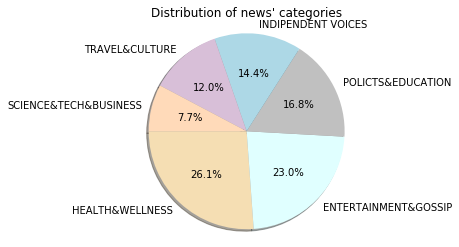

In [64]:
df_pandas= df.toPandas()
labels=df_pandas['group_category'].value_counts().index
values=df_pandas['group_category'].value_counts().values
colors= ['wheat', 'lightcyan', 'silver', 'lightblue', 'thistle', 'peachpuff']
#explode= (0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
plot=plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=180, shadow = True, colors=colors)
plt.title("Distribution of news' categories")
plt.axis('equal')

Il grafico mostra la percentuale di news per ogni macro-categoria dopo l'eliminazione dei record aventi valori mancanti. 

# TEXT MINING


In questa fase abbiamo pensato di ripulire il testo presente in headline e short_description, eliminando caratteri accentati e stopword. 

In [65]:
from pyspark.sql.functions import udf

Per prima cosa abbiamo riportato le due colonne il lowercase. 

In [66]:
lowerUDF = udf(lambda x: x.lower())

In [67]:
df_func = df.withColumn("headline_lower", lowerUDF(col("headline"))).drop('headline')
df_func = df_func.withColumn("s_descr_lower", lowerUDF(col("short_description"))).drop('short_description')

In [68]:
df_func.show()

+-------------+--------------------+--------------------+--------------------+
|     category|      group_category|      headline_lower|       s_descr_lower|
+-------------+--------------------+--------------------+--------------------+
|        CRIME|ENTERTAINMENT&GOSSIP|there were 2 mass...|she left her husb...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|will smith joins ...|of course it has ...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|hugh grant marrie...|the actor and his...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|jim carrey blasts...|the actor gives d...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|julianna margulie...|the "dietland" ac...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|morgan freeman 'd...|"it is not right ...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|donald trump is l...|it's catchy, all ...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|what to watch on ...|there's a great m...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|mike myers reveal...|myer's kids may b...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|what to watch on

Abbiamo poi deciso di sostituire le abbreviazioni con le formule estese in modo tale da standardizzare il testo presente nelle news. 

In [69]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how does",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
" u ": " you ",
" ur ": " your ",
" n ": " and ",
"won't": "would not",
"you're": "you are",
"you'll": "you will",
"you've": "you have",
"you'd": "you would",
"you'd've": "you would have",
"you'll've": "you will have",
"here's" : "here is",
"there's" : "there is",
"where's": "where is"
}

In [70]:
def sub_cont_exp(x):
    if type(x) is str:
        for key in contractions:
            value = contractions[key]
            x = x.replace(key, value)
        return x
    else:
        return x

In [71]:
sub_cont_exp_UDF = udf(lambda x: sub_cont_exp(x))

In [72]:
df_2 = df_func.withColumn("headline_clean", sub_cont_exp_UDF(col("headline_lower"))).drop('headline_lower')
df_l_clean = df_2.withColumn("s_descr_clean", sub_cont_exp_UDF(col("s_descr_lower"))).drop('s_descr_lower')

In [73]:
df_l_clean.show()

+-------------+--------------------+--------------------+--------------------+
|     category|      group_category|      headline_clean|       s_descr_clean|
+-------------+--------------------+--------------------+--------------------+
|        CRIME|ENTERTAINMENT&GOSSIP|there were 2 mass...|she left her husb...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|will smith joins ...|of course it has ...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|hugh grant marrie...|the actor and his...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|jim carrey blasts...|the actor gives d...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|julianna margulie...|the "dietland" ac...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|morgan freeman 'd...|"it is not right ...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|donald trump is l...|it is catchy, all...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|what to watch on ...|there is a great ...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|mike myers reveal...|myer's kids may b...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|what to watch on

Abbiamo eliminato dai testi eventuali link presenti, grazie alla libreria re.

In [74]:
import re 
from unidecode import unidecode

In [75]:
delete_link_UDF = udf(lambda x: re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , x))

In [76]:
df_2 = df_l_clean.withColumn("headline", sub_cont_exp_UDF(col("headline_clean"))).drop('headline_clean')
df_clean = df_2.withColumn("s_descr", sub_cont_exp_UDF(col("s_descr_clean"))).drop('s_descr_clean')

In [77]:
df_clean.show()

+-------------+--------------------+--------------------+--------------------+
|     category|      group_category|            headline|             s_descr|
+-------------+--------------------+--------------------+--------------------+
|        CRIME|ENTERTAINMENT&GOSSIP|there were 2 mass...|she left her husb...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|will smith joins ...|of course it has ...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|hugh grant marrie...|the actor and his...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|jim carrey blasts...|the actor gives d...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|julianna margulie...|the "dietland" ac...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|morgan freeman 'd...|"it is not right ...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|donald trump is l...|it is catchy, all...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|what to watch on ...|there is a great ...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|mike myers reveal...|myer's kids may b...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|what to watch on

Abbiamo provveduto ad eliminare tutti i caratteri speciali, la punteggiatura e riportare i caratteri accentati come caratteri normali. Le librerie utili sono state: re e unidecode. 

In [78]:
char_special_UDF = udf(lambda x: re.sub(r'[^\w ]+', "", x))

In [79]:
df_2 = df_clean.withColumn("headline_c", char_special_UDF(col("headline"))).drop('headline')
df_clean = df_2.withColumn("s_descr_c", char_special_UDF(col("s_descr"))).drop('s_descr')

In [80]:
df_clean.show()

+-------------+--------------------+--------------------+--------------------+
|     category|      group_category|          headline_c|           s_descr_c|
+-------------+--------------------+--------------------+--------------------+
|        CRIME|ENTERTAINMENT&GOSSIP|there were 2 mass...|she left her husb...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|will smith joins ...|of course it has ...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|hugh grant marrie...|the actor and his...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|jim carrey blasts...|the actor gives d...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|julianna margulie...|the dietland actr...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|morgan freeman de...|it is not right t...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|donald trump is l...|it is catchy all ...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|what to watch on ...|there is a great ...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|mike myers reveal...|myers kids may be...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|what to watch on

In [81]:
delete_space_UDF = udf(lambda x: ' '.join(x.split()))

In [82]:
df_2 = df_clean.withColumn("headline", delete_space_UDF(col("headline_c"))).drop('headline_c')
df_clean = df_2.withColumn("s_descr", delete_space_UDF(col("s_descr_c"))).drop('s_descr_c')

In [83]:
df_clean.show()

+-------------+--------------------+--------------------+--------------------+
|     category|      group_category|            headline|             s_descr|
+-------------+--------------------+--------------------+--------------------+
|        CRIME|ENTERTAINMENT&GOSSIP|there were 2 mass...|she left her husb...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|will smith joins ...|of course it has ...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|hugh grant marrie...|the actor and his...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|jim carrey blasts...|the actor gives d...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|julianna margulie...|the dietland actr...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|morgan freeman de...|it is not right t...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|donald trump is l...|it is catchy all ...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|what to watch on ...|there is a great ...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|mike myers reveal...|myers kids may be...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|what to watch on

In [84]:
unidecode_UDF = udf(lambda x: unidecode(x))

In [85]:
df_2 = df_clean.withColumn("headline2", unidecode_UDF(col("headline"))).drop('headline')
df_clean = df_2.withColumn("s_descr2", unidecode_UDF(col("s_descr"))).drop('s_descr')

In [86]:
df_clean.show()

+-------------+--------------------+--------------------+--------------------+
|     category|      group_category|           headline2|            s_descr2|
+-------------+--------------------+--------------------+--------------------+
|        CRIME|ENTERTAINMENT&GOSSIP|there were 2 mass...|she left her husb...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|will smith joins ...|of course it has ...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|hugh grant marrie...|the actor and his...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|jim carrey blasts...|the actor gives d...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|julianna margulie...|the dietland actr...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|morgan freeman de...|it is not right t...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|donald trump is l...|it is catchy all ...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|what to watch on ...|there is a great ...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|mike myers reveal...|myers kids may be...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|what to watch on

Abbiamo ripulito le due colonne eliminando le stopwords al fine di avere un classificatore che non tenga conto delle parole molto frequenti ma poco significative (come preposizioni, articoli etc). 

In [87]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

In [88]:
stopwords_UDF = udf(lambda x: ' '.join([t for t in x.split() if t not in stopwords]))

In [89]:
df_2 = df_clean.withColumn("headline", stopwords_UDF(col("headline2"))).drop('headline2')
df_clean = df_2.withColumn("short_description", stopwords_UDF(col("s_descr2"))).drop('s_descr2')

In [90]:
df_clean.show()

+-------------+--------------------+--------------------+--------------------+
|     category|      group_category|            headline|   short_description|
+-------------+--------------------+--------------------+--------------------+
|        CRIME|ENTERTAINMENT&GOSSIP|2 mass shootings ...|left husband kill...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|smith joins diplo...|         course song|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|hugh grant marrie...|actor longtime gi...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|jim carrey blasts...|actor gives dems ...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|julianna margulie...|dietland actress ...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|morgan freeman de...|right equate horr...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|donald trump lovi...|        catchy right|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|watch amazon prim...|great miniseries ...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|mike myers reveal...|myers kids pushin...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|watch hulu thats

# Sezione aggiuntiva: visualizzazione delle tag cloud

Prima della classificazione vera e propria ci è sembrato interessate visualizzare le tag cloud per headline e short_description in modo da visualizzare le parole più frequenti presenti in headline e short_description. A tal fine abbiamo tokenizzato e lemmatizzato le parole presenti, creando due colonne aggiuntive aventi i tokens. 

In [91]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/hpsa20/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [92]:
tokenizzatore = nltk.tokenize.WhitespaceTokenizer()
stemmer = nltk.stem.WordNetLemmatizer()

In [93]:
def lemmatize_tokenize_text(text):
    return [stemmer.lemmatize(w) for w in tokenizzatore.tokenize(text)]

In [94]:
lemmatize_tokenize_UDF = udf(lambda x: lemmatize_tokenize_text(x))

In [95]:
df_2 = df_clean.withColumn("headline_token", lemmatize_tokenize_UDF(col("headline")))
df_tag = df_2.withColumn("short_description_token", lemmatize_tokenize_UDF(col("short_description")))

In [96]:
df_tag.show()

+-------------+--------------------+--------------------+--------------------+--------------------+-----------------------+
|     category|      group_category|            headline|   short_description|      headline_token|short_description_token|
+-------------+--------------------+--------------------+--------------------+--------------------+-----------------------+
|        CRIME|ENTERTAINMENT&GOSSIP|2 mass shootings ...|left husband kill...|[2, mass, shootin...|   [left, husband, k...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|smith joins diplo...|         course song|[smith, join, dip...|         [course, song]|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|hugh grant marrie...|actor longtime gi...|[hugh, grant, mar...|   [actor, longtime,...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|jim carrey blasts...|actor gives dems ...|[jim, carrey, bla...|   [actor, give, dem...|
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|julianna margulie...|dietland actress ...|[julianna, margul...|   [dietland, actres...|
|ENTERTA

In [97]:
from wordcloud import WordCloud

%matplotlib inline

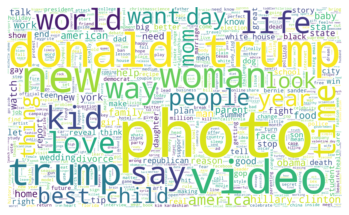

In [98]:
df_tag_pandas= df_tag.toPandas()
text = ' '.join(df_tag_pandas['headline_token'])

wc = WordCloud(width=2000, height=1200, background_color="white", max_words=1000).generate(text)
plt.imshow(wc,  interpolation='bilinear')
plt.axis('off')
plt.show()

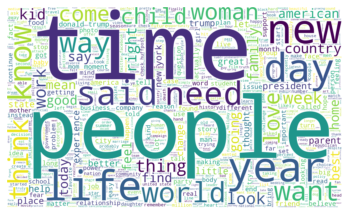

In [99]:
text = ' '.join(df_tag_pandas['short_description_token'])

wc = WordCloud(width=2000, height=1200, background_color="white", max_words=1000).generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Dalle tag-cloud vediamo che:
- in headline le parole più frequenti sono 'photo', 'video', 'trump': parole che possono essere ricondotte alle categorie più rappresentative come intrattenimento e politics:
- in short_description abbiamo molti verbi come 'need' o 'work', ma anche nomi come 'life' o 'women': dalla descrizione risulta quindi esserci una maggiore difficoltà nell'individuare le categorie più rappresentative. 

# Classification

Il nostro scopo nel costruire il classificatore sarà quello di predire la macro-categoria di appartenenza dell'articolo a partire dalle parole presenti nel titolo e nella descrizione breve.

In [171]:
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import NaiveBayes

from pyspark.ml.feature import HashingTF, IDF, Tokenizer

from sklearn.metrics import confusion_matrix

import seaborn as sns

Prima di iniziare la classificazione facciamo ancora qualche operazione di feature engineering per ottenere le variabili nella forma corretta per essere date come input ai classificatori.

In [172]:
df_clean.toPandas()

,category,group_category,headline,short_description
0,CRIME,ENTERTAINMENT&GOSSIP,2 mass shootings texas week 1 tv,left husband killed children day america
1,ENTERTAINMENT,ENTERTAINMENT&GOSSIP,smith joins diplo nicky jam 2018 world cups of...,course song
2,ENTERTAINMENT,ENTERTAINMENT&GOSSIP,hugh grant marries time age 57,actor longtime girlfriend anna eberstein tied ...
3,ENTERTAINMENT,ENTERTAINMENT&GOSSIP,jim carrey blasts castrato adam schiff democra...,actor gives dems asskicking fighting hard dona...
4,ENTERTAINMENT,ENTERTAINMENT&GOSSIP,julianna margulies uses donald trump poop bags...,dietland actress said bags cathartic therapeut...
...,...,...,...,...
181135,TECH,SCIENCE&TECH&BUSINESS,rim ceo thorsten heins significant plans black...,verizon wireless att promoting lte devices inc...
181136,SPORTS,HEALTH&WELLNESS,maria sharapova stunned victoria azarenka aust...,afterward azarenka effusive press normal credi...
181137,SPORTS,HEALTH&WELLNESS,giants patriots jets colts improbable super bo...,leading super bowl xlvi talked game end occurr...
181138,SPORTS,HEALTH&WELLNESS,aldon smith arrested 49ers linebacker busted dui,correction earlier version story incorrectly s...


In [173]:
df_clean.printSchema()

root
 |-- category: string (nullable = true)
 |-- group_category: string (nullable = false)
 |-- headline: string (nullable = true)
 |-- short_description: string (nullable = true)



Controlliamo che non ci siano record con valori nulli

In [174]:
df_clean.registerTempTable('document')
NA_headline = spark.sql('select count (*)  \
                            from document \
                            where group_category is null ')
NA_headline.toPandas()

,count(1)
0,0


In [175]:
df_clean.registerTempTable('document')
NA_headline = spark.sql('select count (*)  \
                            from document \
                            where headline is null ')
NA_headline.toPandas()

,count(1)
0,0


In [176]:
df_clean.registerTempTable('document')
NA_headline = spark.sql('select count (*)  \
                            from document \
                            where short_description is null ')
NA_headline.toPandas()

,count(1)
0,0


### Feature engineering

Indicizziamo la variabile target: group_category.

In [177]:
df_1 = StringIndexer(inputCol="group_category", outputCol="group_category_indexed").fit(df_clean).transform(df_clean)
df_1.printSchema()

root
 |-- category: string (nullable = true)
 |-- group_category: string (nullable = false)
 |-- headline: string (nullable = true)
 |-- short_description: string (nullable = true)
 |-- group_category_indexed: double (nullable = false)



In [178]:
df_1.toPandas().head(5)

,category,group_category,headline,short_description,group_category_indexed
0,CRIME,ENTERTAINMENT&GOSSIP,2 mass shootings texas week 1 tv,left husband killed children day america,1.0
1,ENTERTAINMENT,ENTERTAINMENT&GOSSIP,smith joins diplo nicky jam 2018 world cups of...,course song,1.0
2,ENTERTAINMENT,ENTERTAINMENT&GOSSIP,hugh grant marries time age 57,actor longtime girlfriend anna eberstein tied ...,1.0
3,ENTERTAINMENT,ENTERTAINMENT&GOSSIP,jim carrey blasts castrato adam schiff democra...,actor gives dems asskicking fighting hard dona...,1.0
4,ENTERTAINMENT,ENTERTAINMENT&GOSSIP,julianna margulies uses donald trump poop bags...,dietland actress said bags cathartic therapeut...,1.0


In [179]:
df_1.registerTempTable('df')
indexing = spark.sql('select group_category_indexed, group_category \
                            from df \
                            group by group_category_indexed, group_category')
indexing.toPandas()

,group_category_indexed,group_category
0,5.0,SCIENCE&TECH&BUSINESS
1,1.0,ENTERTAINMENT&GOSSIP
2,0.0,HEALTH&WELLNESS
3,2.0,POLICTS&EDUCATION
4,3.0,INDIPENDENT VOICES
5,4.0,TRAVEL&CULTURE


Di seguito passiamo alla creazione delle features predittive. Per utilizzare l'informazione apportata dalle parole di titolo e descrizione utilizzaremo l'indice TF-IDF che rappresenta l'importanza di una parola in un documento o una collezione di documenti.

Creiamo una sola colonna che comprenda le parole sia del titolo che della descrizione breve. Di queste parole calcoleremo il TF-IDF e useremo tali valori come predittori nel nostro task di classificazione.

In [180]:
df_1 = df_1.withColumn("space", F.lit(" "))
df_1.show(5)

+-------------+--------------------+--------------------+--------------------+----------------------+-----+
|     category|      group_category|            headline|   short_description|group_category_indexed|space|
+-------------+--------------------+--------------------+--------------------+----------------------+-----+
|        CRIME|ENTERTAINMENT&GOSSIP|2 mass shootings ...|left husband kill...|                   1.0|     |
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|smith joins diplo...|         course song|                   1.0|     |
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|hugh grant marrie...|actor longtime gi...|                   1.0|     |
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|jim carrey blasts...|actor gives dems ...|                   1.0|     |
|ENTERTAINMENT|ENTERTAINMENT&GOSSIP|julianna margulie...|dietland actress ...|                   1.0|     |
+-------------+--------------------+--------------------+--------------------+----------------------+-----+
only showing top 5 rows



In [181]:
df_classification = df_1.select('group_category', 'group_category_indexed', F.concat('headline', 'space', 'short_description').alias('news_words'))
df_classification.show(5)

+--------------------+----------------------+--------------------+
|      group_category|group_category_indexed|          news_words|
+--------------------+----------------------+--------------------+
|ENTERTAINMENT&GOSSIP|                   1.0|2 mass shootings ...|
|ENTERTAINMENT&GOSSIP|                   1.0|smith joins diplo...|
|ENTERTAINMENT&GOSSIP|                   1.0|hugh grant marrie...|
|ENTERTAINMENT&GOSSIP|                   1.0|jim carrey blasts...|
|ENTERTAINMENT&GOSSIP|                   1.0|julianna margulie...|
+--------------------+----------------------+--------------------+
only showing top 5 rows



In [182]:
df_classification.toPandas().head(5)

,group_category,group_category_indexed,news_words
0,ENTERTAINMENT&GOSSIP,1.0,2 mass shootings texas week 1 tv left husband ...
1,ENTERTAINMENT&GOSSIP,1.0,smith joins diplo nicky jam 2018 world cups of...
2,ENTERTAINMENT&GOSSIP,1.0,hugh grant marries time age 57 actor longtime ...
3,ENTERTAINMENT&GOSSIP,1.0,jim carrey blasts castrato adam schiff democra...
4,ENTERTAINMENT&GOSSIP,1.0,julianna margulies uses donald trump poop bags...


Prima tokenizziamo la stringa contenente titolo e descrizione.

In [183]:
tokenizer = Tokenizer(inputCol="news_words", outputCol="words")
wordsData = tokenizer.transform(df_classification)

Poi passiamo a calcolare l'indice TF-IDF delle singole parole.

In [184]:
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=4096)
featurizedData = hashingTF.transform(wordsData)

In [185]:
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

In [186]:
rescaledData.show(5) #select("group_category_indexed", "features").show()

+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+
|      group_category|group_category_indexed|          news_words|               words|         rawFeatures|            features|
+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+
|ENTERTAINMENT&GOSSIP|                   1.0|2 mass shootings ...|[2, mass, shootin...|(4096,[109,236,33...|(4096,[109,236,33...|
|ENTERTAINMENT&GOSSIP|                   1.0|smith joins diplo...|[smith, joins, di...|(4096,[722,1047,1...|(4096,[722,1047,1...|
|ENTERTAINMENT&GOSSIP|                   1.0|hugh grant marrie...|[hugh, grant, mar...|(4096,[10,220,234...|(4096,[10,220,234...|
|ENTERTAINMENT&GOSSIP|                   1.0|jim carrey blasts...|[jim, carrey, bla...|(4096,[138,233,23...|(4096,[138,233,23...|
|ENTERTAINMENT&GOSSIP|                   1.0|julianna margulie...|[julianna, margul...|(40

In [187]:
rescaledData.toPandas()

,group_category,group_category_indexed,news_words,words,rawFeatures,features
0,ENTERTAINMENT&GOSSIP,1.0,2 mass shootings texas week 1 tv left husband ...,"[2, mass, shootings, texas, week, 1, tv, left,...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,ENTERTAINMENT&GOSSIP,1.0,smith joins diplo nicky jam 2018 world cups of...,"[smith, joins, diplo, nicky, jam, 2018, world,...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,ENTERTAINMENT&GOSSIP,1.0,hugh grant marries time age 57 actor longtime ...,"[hugh, grant, marries, time, age, 57, actor, l...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,ENTERTAINMENT&GOSSIP,1.0,jim carrey blasts castrato adam schiff democra...,"[jim, carrey, blasts, castrato, adam, schiff, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,ENTERTAINMENT&GOSSIP,1.0,julianna margulies uses donald trump poop bags...,"[julianna, margulies, uses, donald, trump, poo...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...
181135,SCIENCE&TECH&BUSINESS,5.0,rim ceo thorsten heins significant plans black...,"[rim, ceo, thorsten, heins, significant, plans...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
181136,HEALTH&WELLNESS,0.0,maria sharapova stunned victoria azarenka aust...,"[maria, sharapova, stunned, victoria, azarenka...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
181137,HEALTH&WELLNESS,0.0,giants patriots jets colts improbable super bo...,"[giants, patriots, jets, colts, improbable, su...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
181138,HEALTH&WELLNESS,0.0,aldon smith arrested 49ers linebacker busted d...,"[aldon, smith, arrested, 49ers, linebacker, bu...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [188]:
rescaledData.dtypes, rescaledData.count()

([('group_category', 'string'),
  ('group_category_indexed', 'double'),
  ('news_words', 'string'),
  ('words', 'array<string>'),
  ('rawFeatures', 'vector'),
  ('features', 'vector')],
 181140)

Controlliamo che i tipi delle variabili vadano bene per diventare input dei classificatori: la label è un double e le features sono all'interno di un unico vettore quindi va bene.

Selezioniamo dunque le X e y per il modello.

In [189]:
data = rescaledData.select('group_category', 'group_category_indexed', 'features')
data.show()

+--------------------+----------------------+--------------------+
|      group_category|group_category_indexed|            features|
+--------------------+----------------------+--------------------+
|ENTERTAINMENT&GOSSIP|                   1.0|(4096,[109,236,33...|
|ENTERTAINMENT&GOSSIP|                   1.0|(4096,[722,1047,1...|
|ENTERTAINMENT&GOSSIP|                   1.0|(4096,[10,220,234...|
|ENTERTAINMENT&GOSSIP|                   1.0|(4096,[138,233,23...|
|ENTERTAINMENT&GOSSIP|                   1.0|(4096,[423,595,65...|
|ENTERTAINMENT&GOSSIP|                   1.0|(4096,[87,157,500...|
|ENTERTAINMENT&GOSSIP|                   1.0|(4096,[125,691,13...|
|ENTERTAINMENT&GOSSIP|                   1.0|(4096,[228,338,12...|
|ENTERTAINMENT&GOSSIP|                   1.0|(4096,[125,268,59...|
|ENTERTAINMENT&GOSSIP|                   1.0|(4096,[228,231,33...|
|ENTERTAINMENT&GOSSIP|                   1.0|(4096,[207,322,54...|
|      TRAVEL&CULTURE|                   4.0|(4096,[370,772,10

### Train-test split

In [190]:
(trainingData, testData) = data.randomSplit([0.7, 0.3], seed=0)

Controlliamo che train e test siano ugualmente distribuiti

In [191]:
trainingData.select(count("group_category_indexed")).show()

+-----------------------------+
|count(group_category_indexed)|
+-----------------------------+
|                       127019|
+-----------------------------+



In [192]:
trainingData.groupby('group_category_indexed').agg(count("group_category_indexed")/127019).show()

+----------------------+----------------------------------------+
|group_category_indexed|(count(group_category_indexed) / 127019)|
+----------------------+----------------------------------------+
|                   0.0|                      0.2617876065785434|
|                   1.0|                     0.22925704028531166|
|                   4.0|                     0.11966713641266268|
|                   3.0|                     0.14338799707130429|
|                   2.0|                      0.1686598068005574|
|                   5.0|                     0.07724041285162063|
+----------------------+----------------------------------------+



In [193]:
testData.select(count("group_category_indexed")).show()

+-----------------------------+
|count(group_category_indexed)|
+-----------------------------+
|                        54121|
+-----------------------------+



In [194]:
testData.groupby('group_category_indexed').agg(count("group_category_indexed")/54121).show()

+----------------------+---------------------------------------+
|group_category_indexed|(count(group_category_indexed) / 54121)|
+----------------------+---------------------------------------+
|                   0.0|                     0.2606197224737163|
|                   1.0|                    0.23077917998558786|
|                   4.0|                    0.11917739879159661|
|                   3.0|                    0.14474972746253764|
|                   2.0|                    0.16716246928179448|
|                   5.0|                     0.0775115020047671|
+----------------------+---------------------------------------+



## Random Forest Classifier

Instanziamo il classificatore random forest.

In [195]:
rf = RandomForestClassifier(labelCol="group_category_indexed", featuresCol="features", numTrees=64)

Alleniamo il modello sul train e prediciamo i valori della y sul test-set.

In [196]:
model = rf.fit(trainingData)
predictions = model.transform(testData)

predictions.show()

+--------------------+----------------------+--------------------+--------------------+--------------------+----------+
|      group_category|group_category_indexed|            features|       rawPrediction|         probability|prediction|
+--------------------+----------------------+--------------------+--------------------+--------------------+----------+
|ENTERTAINMENT&GOSSIP|                   1.0|(4096,[0,3,131,69...|[17.0966944016577...|[0.26713585002590...|       0.0|
|ENTERTAINMENT&GOSSIP|                   1.0|(4096,[0,96,110,1...|[17.8896684765875...|[0.27952606994667...|       0.0|
|ENTERTAINMENT&GOSSIP|                   1.0|(4096,[0,132,509,...|[17.0966944016577...|[0.26713585002590...|       0.0|
|ENTERTAINMENT&GOSSIP|                   1.0|(4096,[1,87,575,1...|[17.0966944016577...|[0.26713585002590...|       0.0|
|ENTERTAINMENT&GOSSIP|                   1.0|(4096,[1,105,228,...|[17.0966944016577...|[0.26713585002590...|       0.0|
|ENTERTAINMENT&GOSSIP|                  

### Evaluation

Valutazione della performance del classificatore random forest:
- accuracy e test error
- f1-measure - non essendo le classi da predire bilanciate utilizziamo la F1-measure per avere una media tra la precision e la recall del nostro classificatore
- confusion matrix

In [197]:
evaluator = MulticlassClassificationEvaluator(labelCol="group_category_indexed"
                                              , predictionCol="prediction"
                                              , metricName="accuracy") #istanzio l'oggetto valutatore

accuracy = evaluator.evaluate(predictions)
print('accuracy = ', accuracy)
print("Test Error = %g" % (1.0 - accuracy))

accuracy =  0.3180096450545999
Test Error = 0.68199


In [198]:
evaluator = MulticlassClassificationEvaluator(labelCol="group_category_indexed"
                                              , predictionCol="prediction"
                                              , metricName="f1")#istanzio l'oggetto valutatore

f1_measure = evaluator.evaluate(predictions) #applico il valutatore alle mie predizioni
print('f1-measure = ', f1_measure)

f1-measure =  0.20539543948150218


In [199]:
predictions.select('prediction').distinct().show()

+----------+
|prediction|
+----------+
|       0.0|
|       1.0|
|       3.0|
|       2.0|
+----------+



In [200]:
#confusion matrix
y_true = predictions.select('group_category_indexed').toPandas()
y_pred = predictions.select('prediction').toPandas()
cm = confusion_matrix(y_true, y_pred)
cm

array([[14007,    46,    52,     0,     0,     0],
       [11263,   666,   561,     0,     0,     0],
       [ 6470,    58,  2519,     0,     0,     0],
       [ 7606,    69,   140,    19,     0,     0],
       [ 6301,    42,   107,     0,     0,     0],
       [ 4104,    24,    67,     0,     0,     0]])

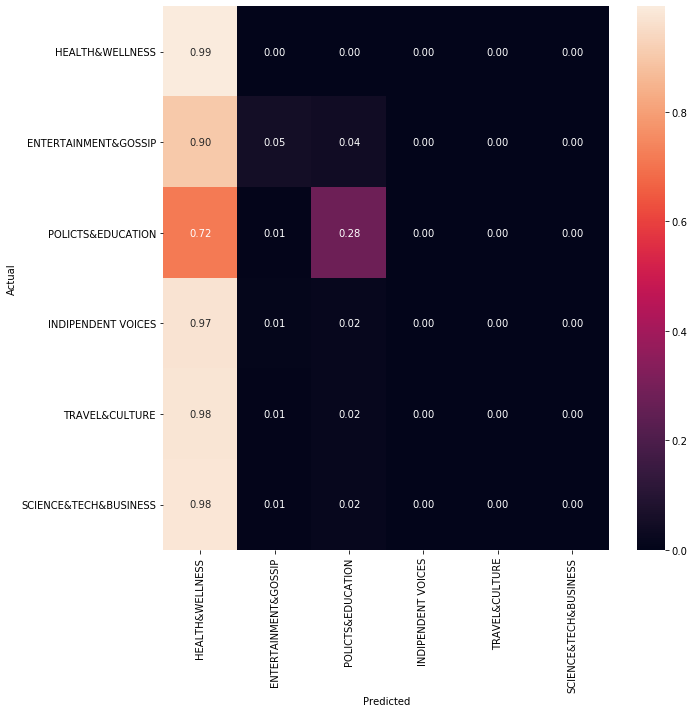

In [201]:
target_names = ['HEALTH&WELLNESS', 'ENTERTAINMENT&GOSSIP', 'POLICTS&EDUCATION', 'INDIPENDENT VOICES', 'TRAVEL&CULTURE', 'SCIENCE&TECH&BUSINESS']
target_names

cmn = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis] #normalizzazione
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## Naive - Bayes Classifier

Instanziamo il classificatore Naive-Bayes.

In [202]:
nb = NaiveBayes(labelCol="group_category_indexed", featuresCol="features", smoothing=1.0, modelType="multinomial")

Alleniamo il modello sul train e prediciamo i valori della y sul test-set.

In [203]:
model = nb.fit(trainingData)
predictions = model.transform(testData)
predictions.show()

+--------------------+----------------------+--------------------+--------------------+--------------------+----------+
|      group_category|group_category_indexed|            features|       rawPrediction|         probability|prediction|
+--------------------+----------------------+--------------------+--------------------+--------------------+----------+
|ENTERTAINMENT&GOSSIP|                   1.0|(4096,[0,3,131,69...|[-431.65762663109...|[0.81501442681103...|       0.0|
|ENTERTAINMENT&GOSSIP|                   1.0|(4096,[0,96,110,1...|[-1532.6776172334...|[0.99999999999999...|       0.0|
|ENTERTAINMENT&GOSSIP|                   1.0|(4096,[0,132,509,...|[-852.97993356902...|[4.83851560769148...|       1.0|
|ENTERTAINMENT&GOSSIP|                   1.0|(4096,[1,87,575,1...|[-830.91214603640...|[3.87277071708653...|       1.0|
|ENTERTAINMENT&GOSSIP|                   1.0|(4096,[1,105,228,...|[-595.95222131259...|[5.73892961327472...|       1.0|
|ENTERTAINMENT&GOSSIP|                  

### Evaluation

Valutazione della performance del classificatore Naive-Bayes:
- accuracy e test error
- f1-measure - non essendo le classi da predire bilanciate utilizziamo la F1-measure per avere una media tra la precision e la recall del nostro classificatore
- confusion matrix

In [204]:
evaluator = MulticlassClassificationEvaluator(labelCol="group_category_indexed", predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))
print("Test Error = %g" % (1.0 - accuracy))

Test set accuracy = 0.5901590879695497
Test Error = 0.409841


In [205]:
evaluator = MulticlassClassificationEvaluator(labelCol="group_category_indexed", predictionCol="prediction",
                                              metricName="f1")
f1_measure = evaluator.evaluate(predictions)
print("f1-measure = " + str(f1_measure))

f1-measure = 0.5920517245817802


In [206]:
predictions.select('prediction').distinct().show()

+----------+
|prediction|
+----------+
|       0.0|
|       1.0|
|       4.0|
|       3.0|
|       2.0|
|       5.0|
+----------+



In [207]:
#confusion matrix
y_true = predictions.select('group_category_indexed').toPandas()
y_pred = predictions.select('prediction').toPandas()
cm = confusion_matrix(y_true, y_pred)
cm

array([[8787, 1391,  460, 1272, 1135, 1060],
       [1356, 6224, 1268, 1678, 1062,  902],
       [ 214,  599, 6586,  473,  516,  659],
       [ 835, 1165,  693, 4350,  420,  371],
       [ 862,  561,  494,  385, 3663,  485],
       [ 454,  352,  357,  282,  420, 2330]])

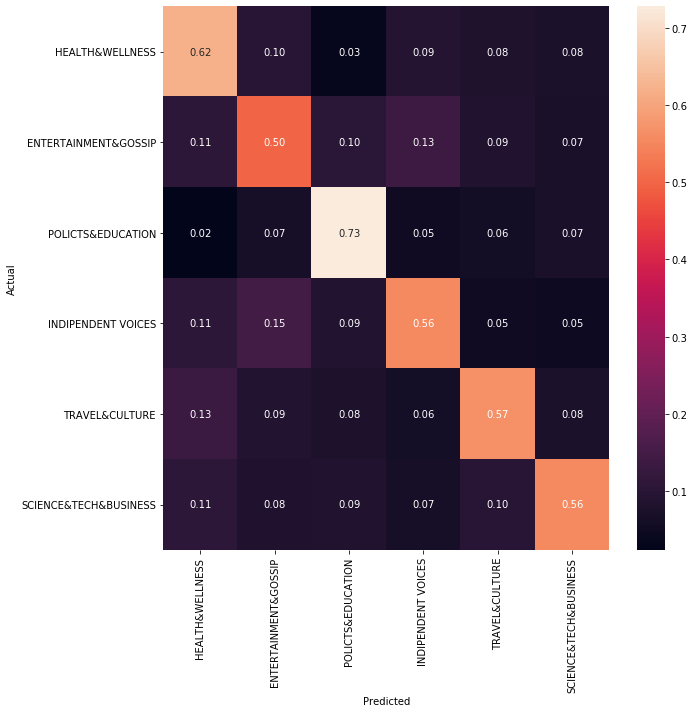

In [208]:
cmn = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis] #normalizzazione
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## Alternativa

In considerazione del fatto che le macro-categorie utilizzate come variabile target sono state da noi create, abbiamo deciso di provare ad utilizzare come target le categorie originali (solo le prime 6 con un numero di articoli maggiore) per verificare se la non altissima performance di almeno uno dei due classificatori fosse dovuta al modo in cui abbiamo deciso di aggregare le categorie tra loro.

In [209]:
df_clean.registerTempTable('document_clean')
df_top6 = spark.sql('select *  \
                from document_clean \
                where (category == "POLITICS") or (category == "WELLNESS") or (category == "ENTERTAINMENT") \
                or (category == "TRAVEL") or (category == "STYLE & BEAUTY") or (category == "PARENTING") ')
df_top6.toPandas()

,category,group_category,headline,short_description
0,ENTERTAINMENT,ENTERTAINMENT&GOSSIP,smith joins diplo nicky jam 2018 world cups of...,course song
1,ENTERTAINMENT,ENTERTAINMENT&GOSSIP,hugh grant marries time age 57,actor longtime girlfriend anna eberstein tied ...
2,ENTERTAINMENT,ENTERTAINMENT&GOSSIP,jim carrey blasts castrato adam schiff democra...,actor gives dems asskicking fighting hard dona...
3,ENTERTAINMENT,ENTERTAINMENT&GOSSIP,julianna margulies uses donald trump poop bags...,dietland actress said bags cathartic therapeut...
4,ENTERTAINMENT,ENTERTAINMENT&GOSSIP,morgan freeman devastated sexual harassment cl...,right equate horrific incidents sexual assault...
...,...,...,...,...
88589,WELLNESS,HEALTH&WELLNESS,beginning surprising advice centenarian,greataunt ida loves beginning gearing 101st bi...
88590,STYLE & BEAUTY,HEALTH&WELLNESS,cheryl tiegs sauna look,look daily column highlights moment fashions f...
88591,PARENTING,INDIPENDENT VOICES,teen responsibility happen nurtured,feel kids today responsible kids generation ag...
88592,ENTERTAINMENT,ENTERTAINMENT&GOSSIP,sundance icet shades american race cinema,representation collective diaspora thwarted ne...


Le categorie selezionate come nuove labels sono risultate dunque le seguenti:

In [210]:
df_top6.groupby("category").count().show()

+--------------+-----+
|      category|count|
+--------------+-----+
|      POLITICS|29578|
|     PARENTING| 8676|
| ENTERTAINMENT|13470|
|STYLE & BEAUTY| 9637|
|        TRAVEL| 9408|
|      WELLNESS|17825|
+--------------+-----+



Indicizziamo la variabile target "category".

In [211]:
df_top6 = StringIndexer(inputCol="category", outputCol="category_indexed").fit(df_top6).transform(df_top6)
df_top6.printSchema()

root
 |-- category: string (nullable = true)
 |-- group_category: string (nullable = false)
 |-- headline: string (nullable = true)
 |-- short_description: string (nullable = true)
 |-- category_indexed: double (nullable = false)



In [212]:
df_top6.toPandas().head(5)

,category,group_category,headline,short_description,category_indexed
0,ENTERTAINMENT,ENTERTAINMENT&GOSSIP,smith joins diplo nicky jam 2018 world cups of...,course song,2.0
1,ENTERTAINMENT,ENTERTAINMENT&GOSSIP,hugh grant marries time age 57,actor longtime girlfriend anna eberstein tied ...,2.0
2,ENTERTAINMENT,ENTERTAINMENT&GOSSIP,jim carrey blasts castrato adam schiff democra...,actor gives dems asskicking fighting hard dona...,2.0
3,ENTERTAINMENT,ENTERTAINMENT&GOSSIP,julianna margulies uses donald trump poop bags...,dietland actress said bags cathartic therapeut...,2.0
4,ENTERTAINMENT,ENTERTAINMENT&GOSSIP,morgan freeman devastated sexual harassment cl...,right equate horrific incidents sexual assault...,2.0


In [213]:
df_top6.registerTempTable('df')
indexing = spark.sql('select category_indexed, category \
                            from df \
                            group by category_indexed, category')
indexing.toPandas()

,category_indexed,category
0,2.0,ENTERTAINMENT
1,4.0,TRAVEL
2,5.0,PARENTING
3,3.0,STYLE & BEAUTY
4,1.0,WELLNESS
5,0.0,POLITICS


In [214]:
df_top6 = df_top6.withColumn("space", F.lit(" "))
df_top6.printSchema()

root
 |-- category: string (nullable = true)
 |-- group_category: string (nullable = false)
 |-- headline: string (nullable = true)
 |-- short_description: string (nullable = true)
 |-- category_indexed: double (nullable = false)
 |-- space: string (nullable = false)



In [215]:
df_classification = df_top6.select('category', 'category_indexed', F.concat('headline', 'space', 'short_description').alias('news_words'))
df_classification.show(5)

+-------------+----------------+--------------------+
|     category|category_indexed|          news_words|
+-------------+----------------+--------------------+
|ENTERTAINMENT|             2.0|smith joins diplo...|
|ENTERTAINMENT|             2.0|hugh grant marrie...|
|ENTERTAINMENT|             2.0|jim carrey blasts...|
|ENTERTAINMENT|             2.0|julianna margulie...|
|ENTERTAINMENT|             2.0|morgan freeman de...|
+-------------+----------------+--------------------+
only showing top 5 rows



In [216]:
df_classification.toPandas().head(10)

,category,category_indexed,news_words
0,ENTERTAINMENT,2.0,smith joins diplo nicky jam 2018 world cups of...
1,ENTERTAINMENT,2.0,hugh grant marries time age 57 actor longtime ...
2,ENTERTAINMENT,2.0,jim carrey blasts castrato adam schiff democra...
3,ENTERTAINMENT,2.0,julianna margulies uses donald trump poop bags...
4,ENTERTAINMENT,2.0,morgan freeman devastated sexual harassment cl...
5,ENTERTAINMENT,2.0,donald trump lovin new mcdonalds jingle tonigh...
6,ENTERTAINMENT,2.0,watch amazon prime thats new week great minise...
7,ENTERTAINMENT,2.0,mike myers reveals like fourth austin powers f...
8,ENTERTAINMENT,2.0,watch hulu thats new week getting recent acade...
9,ENTERTAINMENT,2.0,justin timberlake visits texas school shooting...


Passiamo al calcolo del TF-IDF.

In [217]:
tokenizer = Tokenizer(inputCol="news_words", outputCol="words")
wordsData = tokenizer.transform(df_classification)

In [218]:
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=4096)
featurizedData = hashingTF.transform(wordsData)

In [219]:
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

In [220]:
rescaledData.select("category_indexed", "features").show()

+----------------+--------------------+
|category_indexed|            features|
+----------------+--------------------+
|             2.0|(4096,[722,1047,1...|
|             2.0|(4096,[10,220,234...|
|             2.0|(4096,[138,233,23...|
|             2.0|(4096,[423,595,65...|
|             2.0|(4096,[87,157,500...|
|             2.0|(4096,[125,691,13...|
|             2.0|(4096,[228,338,12...|
|             2.0|(4096,[125,268,59...|
|             2.0|(4096,[228,231,33...|
|             2.0|(4096,[207,322,54...|
|             0.0|(4096,[598,805,11...|
|             0.0|(4096,[287,319,55...|
|             0.0|(4096,[372,522,71...|
|             0.0|(4096,[174,637,13...|
|             0.0|(4096,[761,1066,1...|
|             0.0|(4096,[184,396,46...|
|             0.0|(4096,[302,415,60...|
|             2.0|(4096,[322,433,13...|
|             0.0|(4096,[132,697,96...|
|             0.0|(4096,[289,933,97...|
+----------------+--------------------+
only showing top 20 rows



In [221]:
data = rescaledData.select('category', 'category_indexed', 'features')
data.show()

+-------------+----------------+--------------------+
|     category|category_indexed|            features|
+-------------+----------------+--------------------+
|ENTERTAINMENT|             2.0|(4096,[722,1047,1...|
|ENTERTAINMENT|             2.0|(4096,[10,220,234...|
|ENTERTAINMENT|             2.0|(4096,[138,233,23...|
|ENTERTAINMENT|             2.0|(4096,[423,595,65...|
|ENTERTAINMENT|             2.0|(4096,[87,157,500...|
|ENTERTAINMENT|             2.0|(4096,[125,691,13...|
|ENTERTAINMENT|             2.0|(4096,[228,338,12...|
|ENTERTAINMENT|             2.0|(4096,[125,268,59...|
|ENTERTAINMENT|             2.0|(4096,[228,231,33...|
|ENTERTAINMENT|             2.0|(4096,[207,322,54...|
|     POLITICS|             0.0|(4096,[598,805,11...|
|     POLITICS|             0.0|(4096,[287,319,55...|
|     POLITICS|             0.0|(4096,[372,522,71...|
|     POLITICS|             0.0|(4096,[174,637,13...|
|     POLITICS|             0.0|(4096,[761,1066,1...|
|     POLITICS|             

In [222]:
data.dtypes, data.count()

([('category', 'string'),
  ('category_indexed', 'double'),
  ('features', 'vector')],
 88594)

### Train-test split

In [223]:
(trainingData, testData) = data.randomSplit([0.7, 0.3], seed=0)

In [224]:
trainingData.select(count("category_indexed")).show()

+-----------------------+
|count(category_indexed)|
+-----------------------+
|                  62088|
+-----------------------+



In [225]:
trainingData.groupby('category_indexed').agg(count("category_indexed")/127019).show()

+----------------+----------------------------------+
|category_indexed|(count(category_indexed) / 127019)|
+----------------+----------------------------------+
|             0.0|               0.16312520174147174|
|             1.0|               0.09874900605421236|
|             4.0|               0.05203945866366449|
|             3.0|              0.053259748541556774|
|             2.0|               0.07363465308339698|
|             5.0|               0.04800069280973713|
+----------------+----------------------------------+



In [226]:
testData.select(count("category_indexed")).show()

+-----------------------+
|count(category_indexed)|
+-----------------------+
|                  26506|
+-----------------------+



In [227]:
testData.groupby('category_indexed').agg(count("category_indexed")/54121).show()

+----------------+---------------------------------+
|category_indexed|(count(category_indexed) / 54121)|
+----------------+---------------------------------+
|             0.0|              0.16367029434045935|
|             1.0|              0.09759612719646718|
|             4.0|              0.05169897082463369|
|             3.0|                0.053066277415421|
|             2.0|               0.0760702869496129|
|             5.0|             0.047652482400546925|
+----------------+---------------------------------+



## Random Forest Classifier

In [228]:
rf = RandomForestClassifier(labelCol="category_indexed", featuresCol="features", numTrees=64)

In [229]:
model = rf.fit(trainingData)
predictions = model.transform(testData) #applico il modello ottenuto sul test data

predictions.show()

+-------------+----------------+--------------------+--------------------+--------------------+----------+
|     category|category_indexed|            features|       rawPrediction|         probability|prediction|
+-------------+----------------+--------------------+--------------------+--------------------+----------+
|ENTERTAINMENT|             2.0|(4096,[0,123,240,...|[20.4312390649553...|[0.31923811038992...|       0.0|
|ENTERTAINMENT|             2.0|(4096,[1,43,71,21...|[20.8572549375420...|[0.32589460839909...|       0.0|
|ENTERTAINMENT|             2.0|(4096,[1,109,157,...|[20.3993984056026...|[0.31874060008754...|       0.0|
|ENTERTAINMENT|             2.0|(4096,[3,582,652,...|[20.3536399258446...|[0.31802562384132...|       0.0|
|ENTERTAINMENT|             2.0|(4096,[4,23,1300,...|[20.6331322449472...|[0.32239269132729...|       0.0|
|ENTERTAINMENT|             2.0|(4096,[4,208,236,...|[21.1791493932831...|[0.33092420927004...|       0.0|
|ENTERTAINMENT|             2.0|(4096

### Evaluation

In [230]:
evaluator = MulticlassClassificationEvaluator(labelCol="category_indexed"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")#istanzio l'oggetto valutatore

accuracy = evaluator.evaluate(predictions)
print('accuracy = ', accuracy)
print("Test Error = %g" % (1.0 - accuracy))

accuracy =  0.3466384969440881
Test Error = 0.653362


In [231]:
evaluator = MulticlassClassificationEvaluator(labelCol="category_indexed"
                                              , predictionCol="prediction"
                                              , metricName="f1")#istanzio l'oggetto valutatore

f1_measure = evaluator.evaluate(predictions) #applico il valutatore alle mie predizioni
print('f1-measure = ', f1_measure)

f1-measure =  0.19218499841277123


In [232]:
predictions.select('prediction').distinct().show()

+----------+
|prediction|
+----------+
|       0.0|
|       1.0|
|       3.0|
|       5.0|
+----------+



In [233]:
#confusion matrix
y_true = predictions.select('category_indexed').toPandas()
y_pred = predictions.select('prediction').toPandas()
cm = confusion_matrix(y_true, y_pred)
cm

array([[8858,    0,    0,    0,    0,    0],
       [5226,   56,    0,    0,    0,    0],
       [4117,    0,    0,    0,    0,    0],
       [2607,    0,    0,  265,    0,    0],
       [2798,    0,    0,    0,    0,    0],
       [2563,    7,    0,    0,    0,    9]])

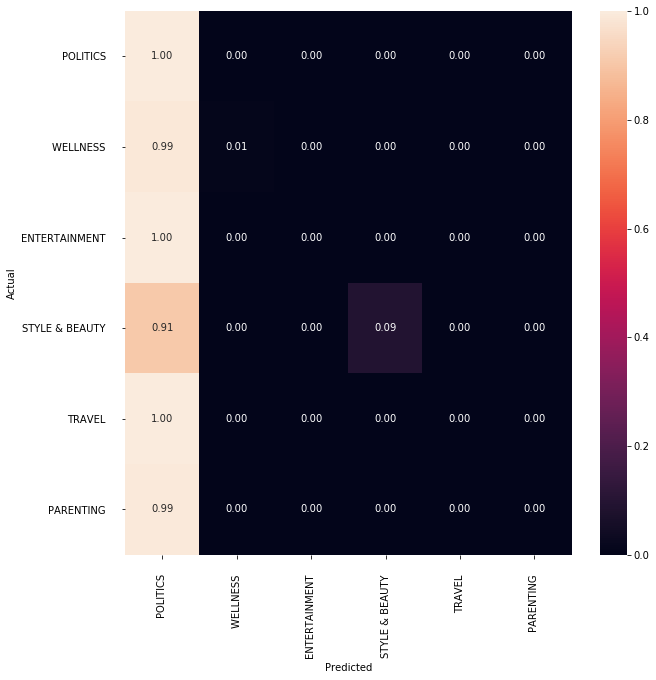

In [234]:
target_names1 = ['POLITICS    ', 'WELLNESS    ', 'ENTERTAINMENT    ', 'STYLE & BEAUTY    ', 'TRAVEL    ', 'PARENTING    ']
target_names1

cmn = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis] #normalizzazione
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names1, yticklabels=target_names1)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## Naive - Bayes Classifier

In [235]:
nb = NaiveBayes(labelCol="category_indexed", featuresCol="features", smoothing=1.0, modelType="multinomial")

In [236]:
model = nb.fit(trainingData)
predictions = model.transform(testData)
predictions.show()

+-------------+----------------+--------------------+--------------------+--------------------+----------+
|     category|category_indexed|            features|       rawPrediction|         probability|prediction|
+-------------+----------------+--------------------+--------------------+--------------------+----------+
|ENTERTAINMENT|             2.0|(4096,[0,123,240,...|[-776.95568295252...|[0.86671782744623...|       0.0|
|ENTERTAINMENT|             2.0|(4096,[1,43,71,21...|[-774.14025118778...|[1.72900306201488...|       2.0|
|ENTERTAINMENT|             2.0|(4096,[1,109,157,...|[-920.93119450277...|[1.00710603967888...|       2.0|
|ENTERTAINMENT|             2.0|(4096,[3,582,652,...|[-522.88285150694...|[1.04157436398210...|       2.0|
|ENTERTAINMENT|             2.0|(4096,[4,23,1300,...|[-637.56368398621...|[1.38496273161309...|       2.0|
|ENTERTAINMENT|             2.0|(4096,[4,208,236,...|[-630.76988212071...|[0.99850678342187...|       0.0|
|ENTERTAINMENT|             2.0|(4096

### Evaluation

In [237]:
evaluator = MulticlassClassificationEvaluator(labelCol="category_indexed", predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))
print("Test Error = %g" % (1.0 - accuracy))

Test set accuracy = 0.7873311703010639
Test Error = 0.212669


In [238]:
evaluator = MulticlassClassificationEvaluator(labelCol="category_indexed", predictionCol="prediction",
                                              metricName="f1")
f1_measure = evaluator.evaluate(predictions)
print("f1-measure = " + str(f1_measure))

f1-measure = 0.7897979513487643


In [239]:
predictions.select('prediction').distinct().show()

+----------+
|prediction|
+----------+
|       0.0|
|       1.0|
|       4.0|
|       3.0|
|       2.0|
|       5.0|
+----------+



In [240]:
#confusion matrix
y_true = predictions.select('category_indexed').toPandas()
y_pred = predictions.select('prediction').toPandas()
cm = confusion_matrix(y_true, y_pred)
cm

array([[7560,  293,  458,   85,  248,  214],
       [ 188, 4031,  198,   88,  267,  510],
       [ 346,  134, 3004,  238,  182,  213],
       [  52,  135,  167, 2230,  136,  152],
       [  90,  148,  129,   93, 2200,  138],
       [  90,  283,  168,   81,  113, 1844]])

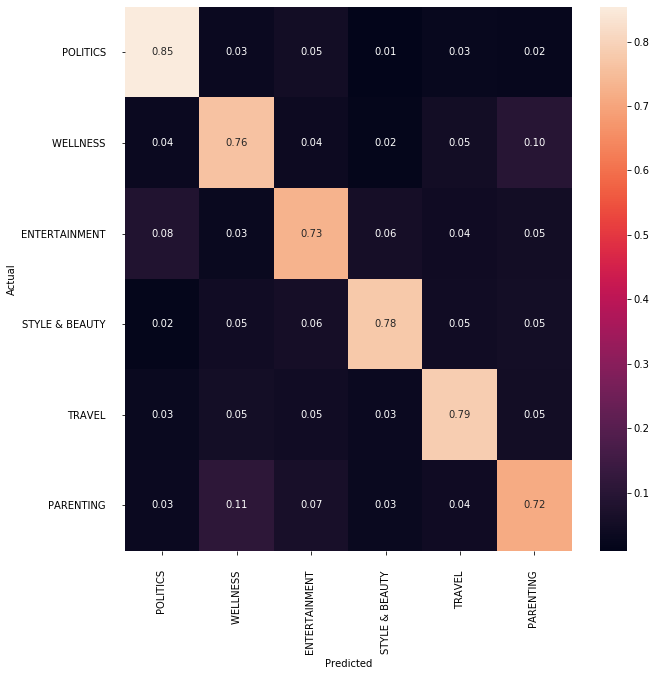

In [241]:
cmn = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis] #normalizzazione
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names1, yticklabels=target_names1)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)